#### Sandbox Demo for CSC

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import random
import os
import yaml

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import sparse_coding_classifier_functions as scc

from AuxiliaryFunctions import showFilters

import pdb
import time

cudaopt = False

ModuleNotFoundError: No module named 'skimage'

Defining Model Class and functions:

In [1]:
# Training Function

def train_SL_CSC(CSC, train_loader, num_epochs, T_DIC, cost_function, optimizer, batch_size):	
    
    print("Training SL-CSC. Batch size is: " + repr(batch_size))
    
    # Initialise variables needed to plot a random sample of three kernels as they are trained
    filter_dims = list(np.shape(CSC.D_trans.weight.data.numpy()))
    idx = random.sample(range(0, filter_dims[0]), 3)
    plt.ion()
    plt.show()
    K_target = CSC.k    # Final and target sparsity 
    CSC.k = 100         # Starting point
    T = time.perf_counter()
    
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = Variable(inputs)
            labels = Variable(labels)
            # Calculate and update step size for sparse coding step
            input_dims = list(inputs.size())
            # Fix dictionary and calculate sparse code
            if CSC.forward_type == 'FISTA_fixed_step':
                CSC.calc_L(input_dims)
            X = CSC.forward(inputs)
            # Fix sparse code and update dictionary
            for j in range(T_DIC):
                # Zero the gradient
                optimizer.zero_grad()
                # Calculate estimate of reconstructed Y
                inputs_recon = CSC.reverse(X)
                # Calculate loss according to the defined cost function between the true Y and reconstructed Y
                loss = cost_function(inputs_recon, inputs)
                # Calculate the gradient of the cost function wrt to each parameters
                loss.backward(retain_graph=True)
                # Update each parameter according to the optimizer update rule (single step)
                optimizer.step()
                # At the end of each batch plot a random sample of kernels to observe progress
                
            
#             print("Average loss per data point at iteration {0:1.0f}".format(j+1) + " of SGD: {0:1.4f}".format(np.asscalar(loss.data.numpy())))

            l2_error_percent = 100*np.sum((inputs-CSC.D(X)).data.numpy()**2)/ np.sum((inputs).data.numpy()**2)
            T = time.perf_counter() - T
            print("Batch number " + repr(i+1) + ". Error: " + repr(l2_error_percent) + ". K = " + repr(CSC.k) + ". Speed: " + repr(input_dims[0]/T) + " Hz")
            T = time.perf_counter()
            # Normalise each atom / kernel
            CSC.normalise_weights()
            # Ensure that weights for the reverse and forward operations are consistent	
            CSC.D_trans.weight.data = CSC.D.weight.data.permute(0,1,3,2)
            
            if i%20==0:
                # adapting sparsity
                CSC.k = max(CSC.k - 5,K_target)
                plt.figure(figsize=(8,16))
                plt.imshow(showFilters(CSC.D.weight.data.numpy(),8,16),cmap='gray');
                plt.show()
        
    # Return trained CSC
    return CSC

def project_onto_sup(X, sup):
    X_numpy = X.data.numpy()
    X_dims = list(np.shape(X_numpy))
    X_new = np.zeros((X_dims[0], X_dims[1], X_dims[2], X_dims[3]))
    for i in range(X_dims[0]):
        for j in range(len(supp)):
            X_new[i][sup[j][0]][sup[j][1]][sup[j][2]] = X_numpy[i][sup[j][0]][sup[j][1]][sup[j][2]]
    X_out = Variable(torch.from_numpy(X_new).type(torch.FloatTensor))
    return X_out


In [36]:

class SL_CSC_IHT(nn.Module):
    def __init__(self, stride=1, dp_channels=1, atom_r=1, atom_c=1, numb_atom=1, T_SC=1, k=1):
        super(SL_CSC_IHT, self).__init__()
        self.D_trans = nn.Conv2d(dp_channels, numb_atom, (atom_r, atom_c), stride, padding=0, dilation=1, groups=1, bias=False)
        self.D = nn.ConvTranspose2d(numb_atom, dp_channels, (atom_c, atom_r), stride, padding=0, output_padding=0, groups=1, bias=False, dilation=1)
        self.normalise_weights()
        self.D_trans.weight.data = self.D.weight.data.permute(0,1,3,2)
        self.k = k
        self.T_SC=T_SC
        self.forward_type = 'IHT'

    def forward(self, Y):
        y_dims = list(Y.data.size())
        w_dims = list(self.D_trans.weight.data.size())
        # Initialise X as zerio tensor
        X = Variable(torch.zeros(y_dims[0], w_dims[0], (y_dims[2]-w_dims[2]+1),(y_dims[3]-w_dims[3]+1)))
        for i in range(0, self.T_SC):
            # Hard threshold each image in the dataset
            X,l2_error = self.linesearch(Y,X)
            
        av_num_zeros_per_image = X.data.nonzero().numpy().shape[0]/y_dims[0]
        percent_zeros_per_image = 100*av_num_zeros_per_image/(y_dims[2]*y_dims[3])
        # pix_error = l2_error/(y_dims[0]*y_dims[2]*y_dims[3])
        error_percent = l2_error*100/(np.sum((Y).data.numpy()**2))
#         print("IHT results: L2 error over batch: {0:1.2f}".format(error_percent) + "% , Av. sparsity: {0:1.2f}".format(percent_zeros_per_image) +"%")
        return X

    def linesearch(self,Y,X):
        # Define search parameter for Armijo method
        c = 0.5
        alpha = .1
        g = self.D_trans(Y-self.D(X))
        HT_arg = X + alpha*g
        X_update = self.Threshold_Tensor(HT_arg, self.k)
#         X_update = self.hard_threshold_k(HT_arg, self.k)
#         Calculate cost of current X location
        l2_error_start = np.sum((Y-self.D(X)).data.numpy()**2)
        # Calculate cost of first suggested update
        l2_error = np.sum((Y-self.D(X_update)).data.numpy()**2)
        # While the cost at the next location is higher than the current one iterate up to a count of 8
        count = 0
        while l2_error >= l2_error_start  and count<=30:
            alpha = alpha*c
            HT_arg = X + alpha*g
            X_update = self.Threshold_Tensor(HT_arg, self.k)
#             X_update = self.hard_threshold_k(HT_arg, self.k)
            l2_error = np.sum((Y-self.D(X_update)).data.numpy()**2)
            count +=1
        # print("l2 error at end of linesearch step:{0:1.2f}".format(l2_error))
#         print(count)
#         return X_update, l2_error, alpha
        l2_error = np.sum((Y-self.D(X_update)).data.numpy()**2)
        return X_update, l2_error

        
    def hard_threshold_k(self, X, k):
        # x is a pytorch variable, extract data tensor and convert to a numpy array
        X_numpy = X.data.numpy()
        X_dims = list(np.shape(X_numpy))
        X_new = np.zeros((X_dims[0], X_dims[1], X_dims[2], X_dims[3]))	
        for i in range(X_dims[0]):
            # copy image data, want to sort elements only for a given image
            abs_coeffs = np.absolute(np.copy(X_numpy[i]))
            # extract a list of the ordered elements
            inds_ordered = np.dstack(np.unravel_index(np.argsort(abs(abs_coeffs).ravel()), (X_dims[1], X_dims[2], X_dims[3])))
            # Identify the support of the k largest elements
            sup = inds_ordered[0][-k:]
            # Update X_new all but the k largest entries of x
            for j in range(len(sup)):
                X_new[i][sup[j][0]][sup[j][1]][sup[j][2]] = X_numpy[i][sup[j][0]][sup[j][1]][sup[j][2]]
        X_out = Variable(torch.from_numpy(X_new).type(torch.FloatTensor))
        return X_out    
    
    
    
    def Threshold_Tensor(self,X,k):
        Gamma = X.clone()
        Gamma = Gamma.view(Gamma.shape[0],Gamma.shape[1])
        m = X.shape[1]
        a,_ = torch.abs(Gamma).data.sort(dim=1,descending=True)
        T = torch.mm(a[:,k].unsqueeze(1),torch.Tensor(np.ones((1,m))))
        mask = Variable(torch.Tensor( (Gamma.data.numpy()>T.numpy()) + 0.))
#         pdb.set_trace()
        Gamma = Gamma * mask
        Gamma = Gamma.view(X.shape)
        return (Gamma)
    
    
    def reverse(self, x):
        out = self.D(x)
        return out

    def normalise_weights(self):
        filter_dims = list(np.shape(self.D.weight.data.numpy()))
        for i in range(filter_dims[0]):
            for j in range(filter_dims[1]):
                self.D.weight.data[i][j] = self.D.weight.data[i][j]/((np.sum(self.D.weight.data[i][j].numpy()**2))**0.5)



Defining Paramters and loading data

In [41]:
# Training hyperparameters
num_epochs = 10
batch_size = 512
T_SC = 10
T_DIC = 1
stride = 1
learning_rate = 1
momentum = 0.9
weight_decay=0
k = 20

# Weight importance of sparsity vs. reconstruction
tau = 0.9

# Local dictionary dimensions
atom_r = 28
atom_c = 28
numb_atom = 128
dp_channels = 1 

# Load MNIST
root = './data'
download = False  # download MNIST dataset or not

# Access MNIST dataset and define processing transforms to proces
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (1.0,))])
# trans = transforms.Compose([transforms.ToTensor()])
train_set = dsets.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dsets.MNIST(root=root, train=False, transform=trans)

idx = list(range(60000))
train_sampler = SubsetRandomSampler(idx)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 sampler = train_sampler,# None
                 shuffle=False) #True


test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

# Intitilise Convolutional Sparse Coder CSC
CSC = SL_CSC_IHT(stride, dp_channels, atom_r, atom_c, numb_atom, T_SC, k)

# Define optimisation parameters
CSC_parameters = [{'params': CSC.D.parameters()}]

# Define training settings/ options
cost_function = nn.MSELoss(size_average=True)
optimizer = torch.optim.SGD(CSC_parameters, lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
# optimizer = torch.optim.Adam(CSC_parameters, lr=0.01)

Training!

Training SL-CSC. Batch size is: 512
Batch number 1. Error: 99.121683426883479. K = 100. Speed: 109.61080839501372 Hz


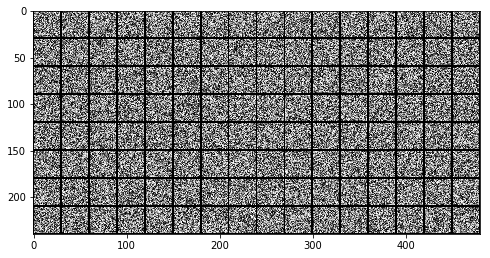

Batch number 2. Error: 99.00942159472055. K = 95. Speed: 123.25776980934901 Hz
Batch number 3. Error: 98.801227202271775. K = 95. Speed: 122.20969989330992 Hz
Batch number 4. Error: 98.522722871027227. K = 95. Speed: 122.46139533444713 Hz
Batch number 5. Error: 98.121423765620847. K = 95. Speed: 122.66225358908409 Hz
Batch number 6. Error: 97.417077869832056. K = 95. Speed: 148.417241396913 Hz
Batch number 7. Error: 96.815542312866285. K = 95. Speed: 138.72423536939888 Hz
Batch number 8. Error: 95.722677518239664. K = 95. Speed: 152.03998987588466 Hz
Batch number 9. Error: 94.449027297480683. K = 95. Speed: 159.45063957255974 Hz
Batch number 10. Error: 92.583138600078357. K = 95. Speed: 160.43193359090873 Hz


In [ ]:
CSC = train_SL_CSC(CSC, train_loader, num_epochs, T_DIC, cost_function, optimizer, batch_size)

Testing model on a few images from the training set


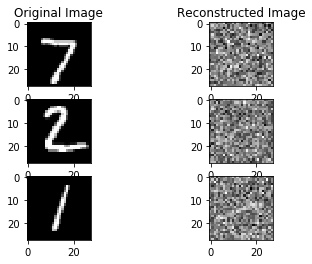

In [11]:

print("Testing model on a few images from the training set")
# Test reconstruction capabilities of trained CSC, first extract some test examples
test_Y = Variable(torch.unsqueeze(test_set.test_data, dim=1), volatile=True).type(torch.FloatTensor)/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_Y =Variable(test_Y.data[:3])
#  Calculate the latent representation
test_X = CSC.forward(test_Y)
test_Y_recon = CSC.reverse(test_X)
# Plot original images side by side with reconstructions to get feel for how successful training was
orig_image1 = test_Y[0][0].data.numpy()
orig_image2 = test_Y[1][0].data.numpy()
orig_image3 = test_Y[2][0].data.numpy()
recon_image1 = test_Y_recon[0][0].data.numpy()
recon_image2 = test_Y_recon[1][0].data.numpy()
recon_image3 = test_Y_recon[2][0].data.numpy()
plt.figure(6)
plt.subplot(3,2,1)
plt.imshow(orig_image1, cmap='gray')
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(recon_image1, cmap='gray')
plt.title('Reconstructed Image')
plt.subplot(3,2,3)
plt.imshow(orig_image2, cmap='gray')
plt.subplot(3,2,4)
plt.imshow(recon_image2, cmap='gray')
plt.subplot(3,2,5)
plt.imshow(orig_image3, cmap='gray')
plt.subplot(3,2,6)
plt.imshow(recon_image3, cmap='gray')
plt.show(block = True)

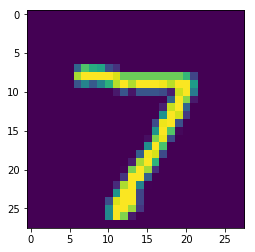

1.0

In [23]:
plt.imshow(test_Y.data.numpy()[0,0,:,:]);
plt.show()
np.mean(test_Y.data.numpy()[1,0,:,:])
np.max(test_Y.data.numpy()[1,0,:,:])